## 第一步 相关的包导入

In [1]:
import pandas as pd
import datetime as dt
import warnings
warnings.filterwarnings("ignore")

import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.rcParams['font.serif'] = ['SimHei']
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus']=False
sns.set_style('ticks', {'font.sans-serif':['simhei','Droid Sans Fallback']})


## 第二步 数据的导入

In [2]:
df_f=pd.read_csv('lesson5_rfm.csv')
del df_f['Unnamed: 0']
df_f.head()

,id,rank,reviews,stars,price,class0,date_d
0,B073Q6KLGQ,1,634,4.8,59.99,Ukuleles,2019-08-26
1,B01N1U7TE7,51,1448,4.6,59.99,Ukuleles,2019-08-26
2,B01F543PAW,2,2452,4.5,59.99,Ukuleles,2019-08-26
3,B077PVV9RR,52,95,4.4,36.99,Ukuleles,2019-08-26
4,B076KFB49J,3,836,4.7,38.99,Ukuleles,2019-08-26


In [3]:
# 产品数量
len(df_f.id.drop_duplicates())

827

In [28]:
df_f.date_d.drop_duplicates()

0        2019-08-26
300      2019-08-27
1301     2019-08-28
2800     2019-08-29
4000     2019-08-30
            ...    
66900    2020-03-04
67200    2020-03-05
67650    2020-03-06
68150    2020-03-07
68400    2020-03-08
Name: date_d, Length: 190, dtype: object

In [4]:
df_f.groupby(['id','date_d'])['id'].value_counts()

id          date_d      id        
B000R4KX88  2019-08-27  B000R4KX88     2
            2019-08-28  B000R4KX88     8
            2019-08-29  B000R4KX88    10
            2019-08-30  B000R4KX88     2
            2019-09-04  B000R4KX88     6
                                      ..
B083W49GJ7  2020-02-24  B083W49GJ7     1
B083W6VN2H  2020-02-23  B083W6VN2H     3
B0842XTXJH  2020-02-29  B0842XTXJH     1
B0849RFGXZ  2020-02-15  B0849RFGXZ     1
            2020-02-20  B0849RFGXZ     1
Name: id, Length: 24709, dtype: int64

In [5]:
# 数据处理，每天抓取周期不唯一，取最小的一次
df_rfm=df_f[['id','rank','date_d']].groupby(['id','date_d'],as_index=False).agg({'rank':'min'})

df_rfm.columns=['id','date_d','rank_min']
df_rfm['date_d'] = pd.to_datetime(df_rfm.date_d)
df_rfm.head()

,id,date_d,rank_min
0,B000R4KX88,2019-08-27,84
1,B000R4KX88,2019-08-28,61
2,B000R4KX88,2019-08-29,46
3,B000R4KX88,2019-08-30,96
4,B000R4KX88,2019-09-04,65


## 第三步 数据清洗

In [6]:
# 判断是否进入top10，作为价值高低的判定依据
df_rfm['isTop10']=df_rfm['rank_min'].apply(lambda x:1 if x<=10 else 0)
df_rfm['isTop10'].value_counts()

0    22568
1     2141
Name: isTop10, dtype: int64

In [8]:
df_rfm[df_rfm['rank_min']>10]

,id,date_d,rank_min,isTop10
0,B000R4KX88,2019-08-27,84,0
1,B000R4KX88,2019-08-28,61,0
2,B000R4KX88,2019-08-29,46,0
3,B000R4KX88,2019-08-30,96,0
4,B000R4KX88,2019-09-04,65,0
...,...,...,...,...
24704,B083W49GJ7,2020-02-24,81,0
24705,B083W6VN2H,2020-02-23,41,0
24706,B0842XTXJH,2020-02-29,87,0
24707,B0849RFGXZ,2020-02-15,78,0


In [9]:
# 距离判断日天数
df_rfm['Datediff']=(pd.to_datetime('2020-03-08')-df_rfm['date_d']).dt.days
# 近三个月
df_rfm_90=df_rfm[df_rfm.Datediff<=90]

In [10]:
df_rfm_90

,id,date_d,rank_min,isTop10,Datediff
29,B000R4KX88,2020-01-15,63,0,53
30,B000R4KX88,2020-01-23,84,0,45
31,B000R4KX88,2020-01-26,64,0,42
32,B000R4KX88,2020-01-27,92,0,41
33,B000R4KX88,2020-02-14,93,0,23
...,...,...,...,...,...
24704,B083W49GJ7,2020-02-24,81,0,13
24705,B083W6VN2H,2020-02-23,41,0,14
24706,B0842XTXJH,2020-02-29,87,0,8
24707,B0849RFGXZ,2020-02-15,78,0,22


## 第三步 RFM指标构建
- R-Recency 最后一次出现在热销榜距离当前时间的天数
- F-Frequecy 上榜频次
- M1-上榜top10的次数
- M2-近3天进入top10位次


Recency 最后一次top排名距离现在是什么时候

In [11]:
# Recency 最后一次top排名据现在是什么时候
R_Agg = df_rfm_90.groupby(by=['id'])['Datediff']
R_Agg = R_Agg.agg([('R-最近一次上榜','min')])
R_Agg

,R-最近一次上榜
id,
B000R4KX88,8
B00172UV6S,27
B00172UVG8,0
B00172YM40,3
B00172YM9U,13
...,...
B083V1Q7LH,14
B083W49GJ7,13
B083W6VN2H,14


In [36]:
R_Agg.describe()

,R-最近一次上榜
count,634.000000
mean,21.198738
std,22.624099
min,0.000000
25%,2.000000
50%,13.000000
75%,36.000000
max,90.000000


F-Frequency 有多少次出现在热销榜上

In [12]:
F_Agg = df_rfm_90.groupby(by=['id'])['rank_min']
F_Agg = F_Agg.agg([('F-上热榜次数','count')])
F_Agg.describe()

,F-上热榜次数
count,634.000000
mean,17.796530
std,25.105614
min,1.000000
25%,2.000000
50%,6.000000
75%,21.000000
max,88.000000


In [13]:
F_Agg

,F-上热榜次数
id,
B000R4KX88,8
B00172UV6S,21
B00172UVG8,87
B00172YM40,47
B00172YM9U,12
...,...
B083V1Q7LH,1
B083W49GJ7,1
B083W6VN2H,1


M1- 上top10榜单次数

In [14]:
#进入top10 打1，没有进入标记为0
M1_Agg = df_rfm_90.groupby(by=['id'])['isTop10']
M1_Agg = M1_Agg.agg([('M1-进入top10次数',sum)])
M1_Agg.sort_values('M1-进入top10次数')

,M1-进入top10次数
id,
B000R4KX88,0
B07HGXBG8H,0
B07HMF159K,0
B07HNTJ533,0
B07J64HCPN,0
...,...
B072JT9WLF,81
B077F1G21S,84
B076KFB49J,86


M2-近三天上top10榜

体现近期

In [15]:
df_rfm_3=df_rfm_90[df_rfm_90.Datediff<=2]
M2_Agg = df_rfm_3.groupby(by=['id'])['isTop10']
M2_Agg = M2_Agg.agg([('M2-近3天进入top10次数',sum)])
M2_Agg.sort_values('M2-近3天进入top10次数')

,M2-近3天进入top10次数
id,
B00172UVG8,0
B07DJ429M8,0
B07DJ4ZGZR,0
B07FNPP7G7,0
B07FYDJ4SV,0
...,...
B077ZRP3J1,3
B073Q6KLGQ,3
B01F543PAW,3


In [16]:
rfm = R_Agg.join(F_Agg).join(M1_Agg).join(M2_Agg)
rfm=rfm.fillna(0)
rfm.head()

,R-最近一次上榜,F-上热榜次数,M1-进入top10次数,M2-近3天进入top10次数
id,,,,
B000R4KX88,8,8,0,0.0
B00172UV6S,27,21,0,0.0
B00172UVG8,0,87,0,0.0
B00172YM40,3,47,0,0.0
B00172YM9U,13,12,0,0.0


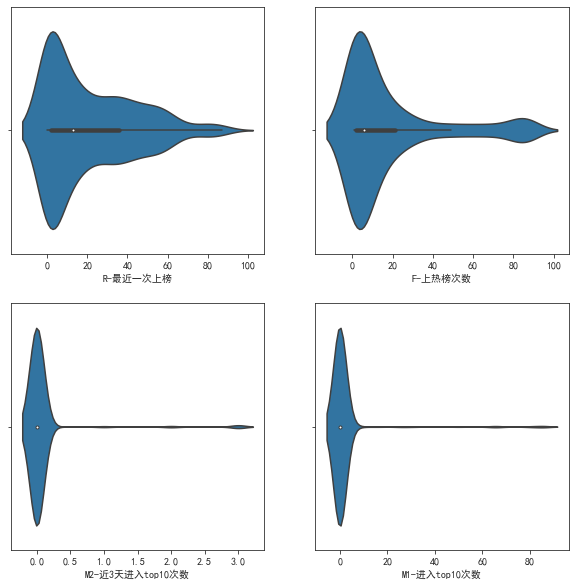

In [17]:
plt.figure(figsize=(10,10))
plt.subplot(221)
sns.violinplot(rfm['R-最近一次上榜'])

plt.subplot(222)
sns.violinplot(rfm['F-上热榜次数'])

plt.subplot(223)
sns.violinplot(rfm['M2-近3天进入top10次数'])

plt.subplot(224)
sns.violinplot(rfm['M1-进入top10次数'])


plt.show()


## 第四步 RFM打分及标签刻画


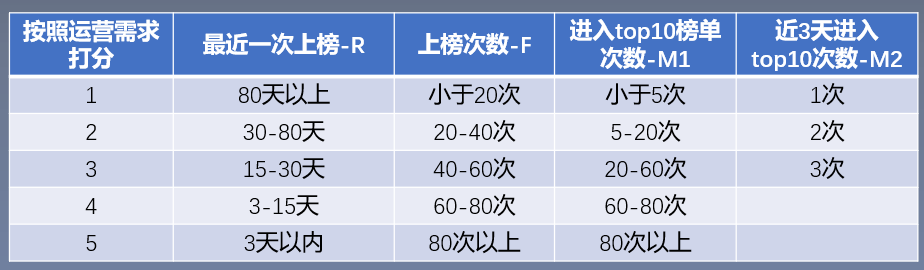

通过pd.cut方法，将用户分层并打上标签，上面小提琴图可以看到是偏态分布，也就是我们常说的长尾分布，所以取均值/分位数来分层无法分出5份，这时候我们通常是与运营协商制定规则

In [19]:
# R
bins = [0,3,15,30,85,1000]
labels =  np.arange(5,0,-1)
rfm['R'] = pd.cut(rfm['R-最近一次上榜'], bins=bins, labels=labels, include_lowest=True).astype(float)

# F
bins = [0,20,40,60,80,1000]
labels =  np.arange(1,6)
rfm['F'] = pd.cut(rfm['F-上热榜次数'], bins=bins, labels=labels, include_lowest=True).astype(float)

# M1
bins = [0,20,40,60,80,1000]
labels =  np.arange(1,6)
rfm['M1'] = pd.cut(rfm['M1-进入top10次数'], bins=bins, labels=labels, include_lowest=True).astype(float)

# M2
bins = [0,1,2,3,100]
labels =  np.arange(0,4)
rfm['M2'] = pd.cut(rfm['M2-近3天进入top10次数'], bins=bins, labels=labels, include_lowest=True).astype(float)

rfm.head()

,R-最近一次上榜,F-上热榜次数,M1-进入top10次数,M2-近3天进入top10次数,R,F,M1,M2
id,,,,,,,,
B000R4KX88,8,8,0,0.0,4.0,1.0,1.0,0.0
B00172UV6S,27,21,0,0.0,3.0,2.0,1.0,0.0
B00172UVG8,0,87,0,0.0,5.0,5.0,1.0,0.0
B00172YM40,3,47,0,0.0,5.0,3.0,1.0,0.0
B00172YM9U,13,12,0,0.0,4.0,1.0,1.0,0.0


In [20]:
rfm.describe()

,R-最近一次上榜,F-上热榜次数,M1-进入top10次数,M2-近3天进入top10次数,R,F,M1,M2
count,634.000000,634.000000,634.000000,634.000000,634.000000,634.000000,634.000000,634.000000
mean,21.198738,17.796530,1.514196,0.059937,3.545741,1.575710,1.063091,0.034700
std,22.624099,25.105614,9.992127,0.392912,1.251333,1.140152,0.452265,0.248968
min,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000
25%,2.000000,2.000000,0.000000,0.000000,2.000000,1.000000,1.000000,0.000000
50%,13.000000,6.000000,0.000000,0.000000,4.000000,1.000000,1.000000,0.000000
75%,36.000000,21.000000,0.000000,0.000000,5.000000,2.000000,1.000000,0.000000
max,90.000000,88.000000,86.000000,3.000000,5.000000,5.000000,5.000000,2.000000


然后我们对不同指标下，高于/低于平均值的，进一步二分

In [21]:
rfm['R_value']=rfm['R'].apply(lambda x:'高' if x> rfm['R'].mean() else '低')
rfm['F_value']=rfm['F'].apply(lambda x:'高' if x> rfm['F'].mean() else '低')
rfm['M1_value']=rfm['M1'].apply(lambda x:'高' if x> rfm['M1'].mean() else '低')
rfm['M2_value']=rfm['M2'].apply(lambda x:'高' if x> rfm['M2'].mean() else '低')
rfm['rfm_value']=rfm['R_value']+rfm['F_value']+rfm['M1_value']+rfm['M2_value']

rfm

,R-最近一次上榜,F-上热榜次数,M1-进入top10次数,M2-近3天进入top10次数,R,F,M1,M2,R_value,F_value,M1_value,M2_value,rfm_value
id,,,,,,,,,,,,,
B000R4KX88,8,8,0,0.0,4.0,1.0,1.0,0.0,高,低,低,低,高低低低
B00172UV6S,27,21,0,0.0,3.0,2.0,1.0,0.0,低,高,低,低,低高低低
B00172UVG8,0,87,0,0.0,5.0,5.0,1.0,0.0,高,高,低,低,高高低低
B00172YM40,3,47,0,0.0,5.0,3.0,1.0,0.0,高,高,低,低,高高低低
B00172YM9U,13,12,0,0.0,4.0,1.0,1.0,0.0,高,低,低,低,高低低低
...,...,...,...,...,...,...,...,...,...,...,...,...,...
B083V1Q7LH,14,1,0,0.0,4.0,1.0,1.0,0.0,高,低,低,低,高低低低
B083W49GJ7,13,1,0,0.0,4.0,1.0,1.0,0.0,高,低,低,低,高低低低
B083W6VN2H,14,1,0,0.0,4.0,1.0,1.0,0.0,高,低,低,低,高低低低


将不同的类别，打上不同的标签，不同的标签，就是不同的产品类型，也就是不同的对待策略

In [23]:
# 分层规则
rfm2cat={
    '高高高高':'持续关注竞品',
    '高高低高':'重点调研老品',
    '高低高高':'重点调研新品',
    '高高高低':'重点保持老品',
    '低低低高':'一般调研新品',
    '高低低高':'一般调研新品',
    '低高高低':'一半调研老品',
    '高高低低':'一般关注老品',
    '低高低低':'一般关注老品',
}

In [24]:
rfm['Label_of_Product']=rfm['rfm_value'].map(rfm2cat)
rfm

,R-最近一次上榜,F-上热榜次数,M1-进入top10次数,M2-近3天进入top10次数,R,F,M1,M2,R_value,F_value,M1_value,M2_value,rfm_value,Label_of_Product
id,,,,,,,,,,,,,,
B000R4KX88,8,8,0,0.0,4.0,1.0,1.0,0.0,高,低,低,低,高低低低,NaN
B00172UV6S,27,21,0,0.0,3.0,2.0,1.0,0.0,低,高,低,低,低高低低,一般关注老品
B00172UVG8,0,87,0,0.0,5.0,5.0,1.0,0.0,高,高,低,低,高高低低,一般关注老品
B00172YM40,3,47,0,0.0,5.0,3.0,1.0,0.0,高,高,低,低,高高低低,一般关注老品
B00172YM9U,13,12,0,0.0,4.0,1.0,1.0,0.0,高,低,低,低,高低低低,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
B083V1Q7LH,14,1,0,0.0,4.0,1.0,1.0,0.0,高,低,低,低,高低低低,NaN
B083W49GJ7,13,1,0,0.0,4.0,1.0,1.0,0.0,高,低,低,低,高低低低,NaN
B083W6VN2H,14,1,0,0.0,4.0,1.0,1.0,0.0,高,低,低,低,高低低低,NaN


In [25]:
rfm['Label_of_Product']=rfm['Label_of_Product'].fillna('暂不关注产品')
rfm['Label_of_Product'].value_counts()

暂不关注产品    469
一般关注老品    149
持续关注竞品     11
重点保持老品      3
一般调研新品      1
重点调研老品      1
Name: Label_of_Product, dtype: int64

In [26]:
# 加权平均RFM分数
rfm['Total_score'] = rfm['R']*0.2 + rfm['F']*0.1 + rfm['M1']*0.2+rfm['M2']*0.5
rfm['update_day']='2020-03-08'

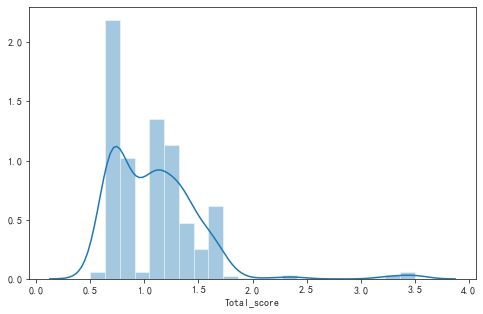

In [27]:
# 分数分布
plt.figure(figsize=(8,5))
sns.distplot(rfm.Total_score)

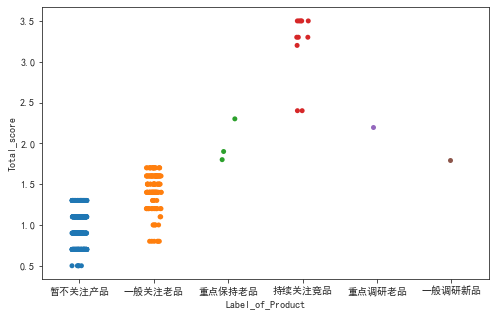

In [28]:
plt.figure(figsize=(8,5))
# stripplot-->分类散点图
sns.stripplot(rfm.Label_of_Product,rfm.Total_score)

### k均值聚类

k均值聚类是基于中心的聚类方法，通过迭代，将样本分到k个类中，使得每个样本与其所属类的中心或均值最近，得到k个平坦的，非层次化的类别，构成对空间的划分。

$k$均值聚类算法，首先选择k个类的中心，将样本分到与中心最近的类中，得到一个聚类结果；然后计算每个类的样本的均值，作为类的新的中心；重复以上步骤，直到收敛为止。

In [29]:
# 利用kmeans来区分
from sklearn.cluster import KMeans
# data
rfm_data=rfm[['R','F','M1','M2']]
kmeans = KMeans(n_clusters=6).fit(rfm_data)
# this creates a new column called cluster which has cluster number for each row respectively.
rfm['cluster'] = kmeans.labels_

In [30]:
rfm['cluster']

id
B000R4KX88    5
B00172UV6S    4
B00172UVG8    0
B00172YM40    0
B00172YM9U    5
             ..
B083V1Q7LH    5
B083W49GJ7    5
B083W6VN2H    5
B0842XTXJH    5
B0849RFGXZ    4
Name: cluster, Length: 634, dtype: int32

In [32]:
# 对比一下
rfm['cluster'].value_counts()

1    200
5    130
2    118
4     89
0     87
3     10
Name: cluster, dtype: int64

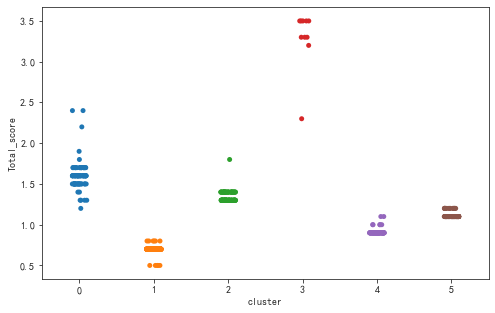

In [33]:
plt.figure(figsize=(8,5))
sns.stripplot(rfm.cluster,rfm.Total_score)

In [36]:
rfm[rfm['cluster']==3]['Label_of_Product'].value_counts()

持续关注竞品    9
重点保持老品    1
Name: Label_of_Product, dtype: int64

In [37]:
rfm[rfm['cluster']==0]['Label_of_Product'].value_counts()

一般关注老品    82
重点保持老品     2
持续关注竞品     2
重点调研老品     1
Name: Label_of_Product, dtype: int64

In [38]:
rfm.head()

,R-最近一次上榜,F-上热榜次数,M1-进入top10次数,M2-近3天进入top10次数,R,F,M1,M2,R_value,F_value,M1_value,M2_value,rfm_value,Label_of_Product,Total_score,update_day,cluster
id,,,,,,,,,,,,,,,,,
B000R4KX88,8,8,0,0.0,4.0,1.0,1.0,0.0,高,低,低,低,高低低低,暂不关注产品,1.1,2020-03-08,5
B00172UV6S,27,21,0,0.0,3.0,2.0,1.0,0.0,低,高,低,低,低高低低,一般关注老品,1.0,2020-03-08,4
B00172UVG8,0,87,0,0.0,5.0,5.0,1.0,0.0,高,高,低,低,高高低低,一般关注老品,1.7,2020-03-08,0
B00172YM40,3,47,0,0.0,5.0,3.0,1.0,0.0,高,高,低,低,高高低低,一般关注老品,1.5,2020-03-08,0
B00172YM9U,13,12,0,0.0,4.0,1.0,1.0,0.0,高,低,低,低,高低低低,暂不关注产品,1.1,2020-03-08,5


In [39]:
# 输出
rfm.to_csv('rfm.csv',encoding='gbk')

# 异常筛选

## 利用pyecharts
```
git clone https://github.com/pyecharts/pyecharts-assets.git
cd pyecharts-assets
jupyter nbextension install assets
jupyter nbextension enable assets/main

from pyecharts.globals import CurrentConfig, OnlineHostType
CurrentConfig.ONLINE_HOST = OnlineHostType.NOTEBOOK_HOST
```

In [60]:
#from pyecharts.globals import CurrentConfig
from pyecharts.globals import CurrentConfig, OnlineHostType
CurrentConfig.ONLINE_HOST = OnlineHostType.NOTEBOOK_HOST
from pyecharts import options as opts
from pyecharts.charts import Bar,Pie,Boxplot

tmp = rfm.groupby('Label_of_Product').size()
t = [[x,int(y)] for x,y in zip(tmp.index.values, tmp.values)]
t

[['一般关注老品', 149],
 ['一般调研新品', 1],
 ['持续关注竞品', 11],
 ['暂不关注产品', 469],
 ['重点保持老品', 3],
 ['重点调研老品', 1]]

In [61]:
# 绘制饼图
pie = (
    Pie()
    .add('',t,
     radius=['30%','75%'],
     rosetype='radius',
     label_opts=opts.LabelOpts(is_show=True))
    .set_global_opts(title_opts=opts.TitleOpts(title='竞品分层结构',pos_left='center'),
                     legend_opts=opts.LegendOpts(orient='vertical',pos_right='2%',pos_top='30%'))
    .set_series_opts(label_opts=opts.LabelOpts(formatter='{b}:{d}%')))
pie.render_notebook()